In [1]:
import gym
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import namedtuple, deque
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import warnings
warnings.filterwarnings("ignore")

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('MountainCarContinuous-v0')
n_actions = env.action_space.shape[0]
n_states = env.observation_space.shape[0]

### Replay Buffer

In [4]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))


class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Noise

In [6]:
class Noise:
    def __init__(self, mu, theta, sigma, action_dim):
        self.mu = mu
        self.theta = theta
        self.sigma = sigma
        self.action_dim = action_dim
        self.state = self.reset()

    def reset(self):
        return np.full(self.action_dim, self.mu)

    def make_noise(self):
        delta = self.theta *(self.mu - self.state) + self.sigma * np.random.randn(len(self.state))
        self.state = self.state + delta
        return self.state

### Critic

In [7]:
class ValueNetwork(nn.Module):
    def __init__(self, hidden_size_1, hidden_size_2, input_size, action_size):
        super(ValueNetwork, self).__init__()

        self.linear1 = nn.Linear(input_size, hidden_size_1)
        self.linear2 = nn.Linear(hidden_size_1 + action_size, hidden_size_2)
        self.linear3 = nn.Linear(hidden_size_2, 1)

    def forward(self, state, action):
        x = F.relu(self.linear1(state))
        x = torch.cat((x, action), dim=1)
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x

### Actor

In [8]:
class PolicyNetwork(nn.Module):
    def __init__(self, hidden_size_1, hidden_size_2, input_size, action_size):
        super(PolicyNetwork, self).__init__()

        self.linear1 = nn.Linear(input_size, hidden_size_1)
        self.linear2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.linear3 = nn.Linear(hidden_size_2, action_size)

    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = F.tanh(self.linear3(x))
        return x

### Model for DDPG

* Метод Q_estimate - считает Q(s, a) при помощи онлайн Критик сети
* Метод Q_target - тоже самое, при помощи таргет Критик сети
* Методы action_estimate и action_target - аналогично, только для вычисления действий от стейта при помощи Актор сетей
* Методы update_*_params делают бэкпроп и градиентные шаги для соответствующих сетей
* Метод Actor_loss - лосс функция для Актор сети
* Метод update_target_networks - обновляет таргет сети при помощи софт апдейт метода

In [9]:
class DDPG:
    def __init__(self, layers_sizes, polyak=0.9999,\
                 critic_lr=0.0001, critic_optim_method=optim.Adam, critic_loss=F.mse_loss, \
                 actor_lr=0.0001, actor_optim_method=optim.Adam):
        self.polyak = polyak

        self.CriticEstimate = ValueNetwork(*layers)
        self.CriticTarget = ValueNetwork(*layers)
        self.CriticTarget.load_state_dict(self.CriticEstimate.state_dict())
        self.critic_loss = critic_loss
        self.critic_optimizer = critic_optim_method(self.CriticEstimate.parameters(), lr=critic_lr)

        self.ActorEstimate = PolicyNetwork(*layers)
        self.ActorTarget = PolicyNetwork(*layers)
        self.ActorTarget.load_state_dict(self.ActorEstimate.state_dict())
        self.actor_optimizer = actor_optim_method(self.ActorEstimate.parameters(), lr=actor_lr)

    def Q_estimate(self, state, action):
        return self.CriticEstimate(state, action)

    def Q_target(self, state, action):
        return self.CriticTarget(state, action)

    def action_estimate(self, state):
        return self.ActorEstimate(state)

    def action_target(self, state):
        return self.ActorTarget(state)

    def update_critic_params(self, estimates, targets):
        loss = self.critic_loss(estimates, targets)
        self.critic_optimizer.zero_grad()
        loss.backward()

        for param in self.CriticEstimate.parameters():
            param.grad.data.clamp_(-1, 1)
        self.critic_optimizer.step()

    def update_actor_params(self, states):
        loss = self.actor_loss(states)
        self.actor_optimizer.zero_grad()
        loss.backward()

        for param in self.ActorEstimate.parameters():
            param.grad.data.clamp_(-1, 1)
        self.actor_optimizer.step()

    def actor_loss(self, states):
        actions = self.action_estimate(states)
        return -self.Q_estimate(states, actions).mean()

    def update_target_networks(self):
        self.soft_update(self.ActorEstimate, self.ActorTarget)
        self.soft_update(self.CriticEstimate, self.CriticTarget)

    def soft_update(self, estimate_model, target_model):
        for estimate_param, target_param in zip(estimate_model.parameters(), target_model.parameters()):
            target_param.data.copy_(target_param.data * self.polyak + estimate_param * (1 - self.polyak))

    def save(self, name):
        torch.save(self.ActorEstimate, name)
        print('------ Model saved ------')

### Agent 

* Использует ДДПГ для обучения
* Первые **exploration episodes** делает действия, которые сэмплятся из равномерного распределения
* В последующих эпизодах сэмплит действия при помощи Актор сети + нойз
* Использует experience replay после каждого шага
* Софт апдейт таргет сетей в конце каждого шага
* Собираем скор каждого эпизода в список. Если пять раз подряд средний скор за последние 10 эпизодов был больше 91, то останавливаем обучение
* Использует модифицированную награду - плюс 10 * модуль скорости

* Метод act - делает действие с помощью Актор сети
* Метод optimize - это фактически experience replay
* Метод train - обучение агента
* Метод test - тестирует агента на заданном количестве эпизодов
* Метод save - сохраняет Актор сеть в файл

In [11]:
class Agent:
    def __init__(self, env, Model, noise, goal, min_score, \
                gamma=0.99, batch_size=64, memory_size=100000, max_episode=2000, upd_rate=1, exploration_episodes=10):
        self.env = env
        self.Model = Model
        self.noise = noise
        self.goal = goal
        self.min_score = min_score

        self.gamma = gamma
        self.batch_size = batch_size
        self.memory = ReplayMemory(memory_size)
        self.max_episode = max_episode
        self.target_update_rate = upd_rate
        self.exploration_episodes = exploration_episodes

    def act(self, state, eps):
        with torch.no_grad():
            action = self.Model.action_estimate(state)
            noise = torch.tensor(eps * self.noise.make_noise()).unsqueeze(0)
            action += noise
        return action.clamp_(self.env.action_space.low[0], self.env.action_space.high[0])

    def optimize(self):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        next_state_batch = torch.cat(batch.next_state)
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
        done_batch = torch.cat(batch.done)

        estimates = self.Model.Q_estimate(state_batch, action_batch)
        Q_next = torch.zeros(self.batch_size, device=device).unsqueeze(1)
        with torch.no_grad():
            next_actions = self.Model.action_target(next_state_batch)
            Q_next[~done_batch] = self.Model.Q_target(next_state_batch, next_actions)[~done_batch]
        targets = reward_batch.unsqueeze(1) + self.gamma * Q_next
        self.Model.update_critic_params(estimates, targets)
        self.Model.update_actor_params(state_batch)


    def train(self):
        all_scores = []
        successful_sequences = 0
        step = 0
        eps = 1
        for ep in range(1, self.max_episode + 1):
            state = self.env.reset()
            state = torch.tensor(state).to(device).float().unsqueeze(0)
            done = False
            episode_reward = 0

            while not done:
                if ep > self.exploration_episodes:
                    action = self.act(state, eps)
                else:
                    action = torch.tensor([np.random.uniform(self.env.action_space.low[0], self.env.action_space.high[0])])
                    action = action.unsqueeze(0)
                action = torch.tensor(action).to(device)
                next_state, reward, done, info = self.env.step(action)
                episode_reward += reward

                modified_reward = reward + 10 * abs(next_state[1])

                next_state = torch.tensor(next_state).to(device).float().unsqueeze(0)
                modified_reward = torch.tensor(modified_reward).to(device).float().unsqueeze(0)
                done = torch.tensor(done).to(device).unsqueeze(0)

                self.memory.push(state, action, next_state, modified_reward, done)
                state = next_state

                self.optimize()

                step += 1
                if step % self.target_update_rate == 0:
                    self.Model.update_target_networks()

                if done:
                    if episode_reward > self.min_score:
                        print(episode_reward, 'at episdoe', ep)

            eps = max(eps * 0.95, 0.1)
            all_scores.append(episode_reward)

            if ep % 10 == 0:
                print('episode', ep, ':', np.mean(all_scores[:-10:-1]), 'average score')

            if np.mean(all_scores[:-15:-1]) >= self.goal:
                successful_sequences += 1
                if successful_sequences == 5:
                    print('success at episode', ep)
                    return all_scores
            else:
                successful_sequences = 0

        return all_scores

    def test(self, episodes=100, render=False):
        state = self.env.reset()
        state = torch.tensor(state).to(device).float().unsqueeze(0)
        ep_count = 0
        current_episode_reward = 0
        scores = []
        while ep_count < episodes:
            if render:
                self.env.render()
            action = self.act(state, 0)
            state, reward, done, _ = self.env.step(action)
            state = torch.tensor(state).to(device).float().unsqueeze(0)
            current_episode_reward += reward

            if done:
                ep_count += 1
                scores.append(current_episode_reward)
                current_episode_reward = 0
                state = self.env.reset()
                state = torch.tensor(state).to(device).float().unsqueeze(0)

        print('average score:', sum(scores) / len(scores))
        print('max reward:', max(scores))
        print('-----')
        print()

    def save(self, name='DDPG_agent.pkl'):
        self.Model.save(name)


### Подготовим агента

In [16]:
layers = (256, 256, n_states, n_actions)

Model = DDPG(layers, polyak=0.999, \
            critic_lr=0.001, critic_optim_method=optim.Adam, critic_loss=F.mse_loss, \
            actor_lr=0.0001, actor_optim_method=optim.Adam)

noise = Noise(0, 0.15, 0.2, n_actions)

MountainCarAgent = Agent(env, Model, noise, goal=91, min_score=-100, \
                gamma=0.9, batch_size=128, memory_size=20000, max_episode=100, upd_rate=1, exploration_episodes=10)

#### Запустим обучение

In [17]:
scores = MountainCarAgent.train()

-31.474966296827183 at episdoe 1
-32.3332240106789 at episdoe 2
-33.21047735648885 at episdoe 3
-32.50320925156587 at episdoe 4
-33.31074066166956 at episdoe 5
-33.117876987029035 at episdoe 6
-33.60144792398803 at episdoe 7
-34.48103695576966 at episdoe 8
-32.990729177490145 at episdoe 9
-34.96613735812459 at episdoe 10
episode 10 : -33.3905421869783 average score
96.90255742849581 at episdoe 11
95.40419095742763 at episdoe 12
95.64473290673475 at episdoe 13
95.21930040929921 at episdoe 14
94.77367090795892 at episdoe 15
94.60065728532072 at episdoe 16
96.33985691272693 at episdoe 17
95.86782104828362 at episdoe 18
96.34561538256686 at episdoe 19
95.41110178715576 at episdoe 20
episode 20 : 95.51188306638603 average score
96.19968165833617 at episdoe 21
94.5589985649333 at episdoe 22
95.73672180062093 at episdoe 23
92.7515445953659 at episdoe 24
91.5378381311591 at episdoe 25
94.22952361989223 at episdoe 26
90.53419155856346 at episdoe 27
91.33060599457602 at episdoe 28
success at epi

#### Протестируем агента на 100 эпизодах

In [18]:
MountainCarAgent.test(episodes=100)

average score: 92.04654421247142
max reward: 94.95437940711322
-----



#### Построим график обучения

Как можно заметить, первые 10 эпизодов агент делает абсолютно рандомные действия из равномерного распределения.
В среднем это дает -33 скора за каждый эпизод, все это время агент так же сохраняет в буфер транзишны и обучается на батчах. Таким образом, по идее, к 11 эпизоду агент гарантированно выбивает 90+- скора и в локальный минимум не попадает. В итоге за последующие ~20 эпизодов агент обучается на действиях, которые дают нормальный скор. После этого обучение автоматом останавливается и обученный агент способен решить поставленную задачу

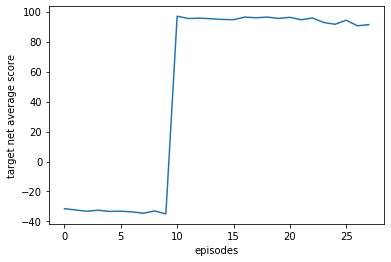

In [19]:
episodes = range(len(scores))
plt.plot(episodes, scores)
plt.xlabel('episodes')
plt.ylabel('target net average score')
plt.show()